# Pebble_Model Package

This is the typical usage of Pebble_Model used to couple DEM and Monte Carlo simulation for depletion simulation. 



## Example: Modelling HTR-10 Benchmark Model

Here is the example of the usage of Pebble_Model module to model HTR-10 reactor core within this [reference](https://www-pub.iaea.org/MTCD/publications/PDF/te_1382_web/TE_1382_Part2.pdf). This example also demonstrate the recirculation scheme used in [this publication](https://iopscience.iop.org/article/10.1088/1742-6596/2048/1/012031).

In [1]:
'''
_______________________________________________________________________________
============================Import all the library=============================
_______________________________________________________________________________
'''
import Pebble_Model as PU
import HTR10

import openmc
import openmc.deplete

%matplotlib inline
import argparse
import os
import math
import pandas as pd

Let's first start by defining the cross section path and the depletion chain used for simulation. If the cross section path already included in '$PATH', then skip this line. the chain can be obtained using ENDF chain or Simplified Chain from [this link](https://openmc.org/depletion-chains/). The chain used for reading the fission product from depletion result after simulating one step of DEM.

In [2]:
CS_path  = 'Nuclear_Library/jeff-3.3-hdf5/cross_sections.xml'
chain    = "./chain_casl_pwr.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = CS_path

The DEM files are included in this DEM_post directory of this examples. It start from dump number 8600000. For DEM step-i and t in timeline, the dump number equal to $8600000+(10000\times t_i)+i\times100000$. 

In [3]:
initial  = 8600000
deltas   = 10000
timeline = [0,7,14,21,28,38,48,58,68,98,128,158,188,218,248,278,308]

The fuel consists of UO$_2$ (17% enrichment) with slight absorber modelled as Boron. The date obtained from [benchmark](https://www-pub.iaea.org/MTCD/publications/PDF/te_1382_web/TE_1382_Part2.pdf).

In [4]:
atom_fraction = [3.99198e-3, 1.92441e-2, 4.64720e-2, 4.06384e-7, 1.63575e-6]

Initial_condition = [['U235','U238','O16','B10','B11'],
                     [x/sum(atom_fraction) for x in atom_fraction]]

Next, we need to define the object of Pebble (Pebble list from DEM dump) and Fisile (Material composition of each TRISO kernel in each Pebble in each Pebble group). Pebble object initiated by DEM step and the number of DEM step simulated. Fisile object initiated by DEM step, timeline, burn power (10 MW) for each DEM step (timeline) and the chain. The power for Fisile can be different for each timeline. 

TRISO position inside pebble is fully randomized using **sparse_TRISO** module. **random_ordered_TRISO** module used if one want to create a TRISO in grid, with TRISO position inside each grid randomized with **combination** position.  

In [5]:
Pebble=PU.DEM_data(0,len(timeline))
Fisile=PU.Recirculation(0,timeline,[10]*len(timeline),chain)
TRIpos=PU.sparse_TRISO(n=8335,r_TRISO=0.04075,r_PEBBLE=2.5)

Pebble object need to read the DEM dump in DEM_post before modelling. The dump should be in format of ASCII .vtk.

After read, each Pebble need to be labeled according to axial, radial and angular position (with **radial_axial** method). The core segmented into 5 axial segment, 3 radial segment and 1 angle segment total ($5\times3\times1 = 15$ group/label). Each pebble labeled by its segment (read [reference](https://iopscience.iop.org/article/10.1088/1742-6596/2048/1/012031) for detail). If one want to label each pebble uniquely, **individual_grouping** method can be used.

In [6]:
filepath = int(initial+(deltas*timeline[0])+0*100000)
Pebble.read('./DEM_post/pebble_'+str(filepath)+'.vtk')
Pebble.label(PU.radial_axial,axial_segment=5,radial_segment=3,angle_segment=1)

pd.DataFrame({k: Pebble.Pebbledf[k] for k in Pebble.Pebbledf.keys()& {'id','x','y','z','rho','theta','type','label'}})

,theta,y,z,rho,label,id,type,x
0,3.936437,-14.79930,-140.186,0.207344,0,1,2,-14.52230
1,4.770717,-21.41170,-140.189,0.214482,0,2,2,1.25033
2,4.494693,-18.86920,-140.185,0.193253,0,3,2,-4.17389
3,1.917855,19.95680,-140.184,0.212221,0,4,2,-7.21836
4,2.490772,12.92990,-140.190,0.213421,0,5,2,-16.97950
...,...,...,...,...,...,...,...,...
28015,3.408225,-22.86840,179.582,0.867921,0,28016,1,-83.72520
28016,5.987353,-3.30493,204.431,0.113362,13,28017,1,10.84380
28017,4.936528,-15.57240,205.120,0.159719,13,28018,1,3.55003
28018,4.014449,-12.44580,204.878,0.162442,0,28019,2,-10.43920


Next, we can assign initial material for each group/label using **add** method from Fisile object. The Fissile object should have material equal to number of group in Pebble object.

In [7]:
for j in range(0,max(Pebble.Pebbledf['label'])):
    Fisile.add(Initial_condition[0],Initial_condition[1],10.4,
               8335*(4/3)*math.pi*(0.025**3),
               j,Pebble.Pebbledf,fraction_type='atom fr')
Fisile.write_material()

print('atom den [atom/b-cm]')
pd.DataFrame.from_dict({k: Fisile.matlist[0][k] for k in Fisile.matlist[0].keys()& {'atom den','atom fr','mass fr','isotope'}})

atom den [atom/b-cm]


,atom fr,isotope,mass fr,atom den
0,0.057265,U235,1.498160e-01,0.595560
1,0.276059,U238,7.314361e-01,2.871013
2,0.666646,O16,1.187444e-01,6.933122
3,0.000006,B10,6.489906e-07,0.000061
4,0.000023,B11,2.873502e-06,0.000244


Now we can make the Core universe using **HTR10** modelling module with **Pebble.Pebbledf** and **Fisile.kernel_material** object variables. Core object will create OpenMC material, cell, and universe that model all pebble and coolant in the core. Core object can also temporarily visualize the universe created by it.

In [8]:
Core = HTR10.HTR10_Core_Universe(Pebble.Pebbledf,Fisile.kernel_material)
Core.create_TRISO()
Core.create_Pebble(TRIpos)
Core.create_Core()
#Core.visualize(res=400,dirs='visualize/')

HTR10 module can also made the control rod universe. In this tutorial we create 0.5 control rod insertion.

In [9]:
CRod   = HTR10.HTR10_Control_Universe()
CRod.create_rod(0.5)

Then, we can use CRod and Core object universe to create full model of the core with predefined material and position in **Table_34** which based on table 34 [reference](https://www-pub.iaea.org/MTCD/publications/PDF/te_1382_web/TE_1382_Part2.pdf). After, Create_Material and Create_Geometry, we have object parameter **root_universe**.

In [10]:
HTRten = HTR10.HTR10_Reactor_Universe(Pebble.Pebbledf,CRod.control_univ,Core.Coreuniverse)
HTRten.Read_Table_34()
HTRten.Create_Material()
HTRten.Create_Geometry()

Next, we can use the material from **CRod, Core and HTRten object** and the geometry from **root_universe** from object HTRten to make OpenMC input file.

In [11]:
os.chdir('./0')
geometry = openmc.Geometry()
geometry.root_universe=HTRten.root_universe
geometry.export_to_xml()

materials=openmc.Materials(HTRten.Reflector_mat+CRod.control_matr+Core.matr_collection)
materials.export_to_xml()

settings = openmc.Settings()
settings.batches = 11
settings.inactive = 1
settings.particles = int(500)
settings.material_cell_offsets=False

bounds=[-90,-90,0,90,90,180]
source=openmc.Source()
source.space=openmc.stats.Box(bounds[:3], bounds[3:],only_fissionable=False)
settings.source = source

settings.export_to_xml()
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [12]:
# =======================================================================
# ------------------------untested for burnup----------------------------
# =======================================================================

#operator   = openmc.deplete.Operator(geometry, settings, "../chain_casl_pwr.xml")
#power      = 10e6
#days       = timeline[1]-timeline[0]
#timesteps  = [days * 24 *60 *60] *1
#integrator = openmc.deplete.PredictorIntegrator(operator,timesteps,power)
#integrator.integrate()


========Print to PPM plots========


convert: /bin/../lib/././libuuid.so.1: no version information available (required by /lib/x86_64-linux-gnu/libSM.so.6)


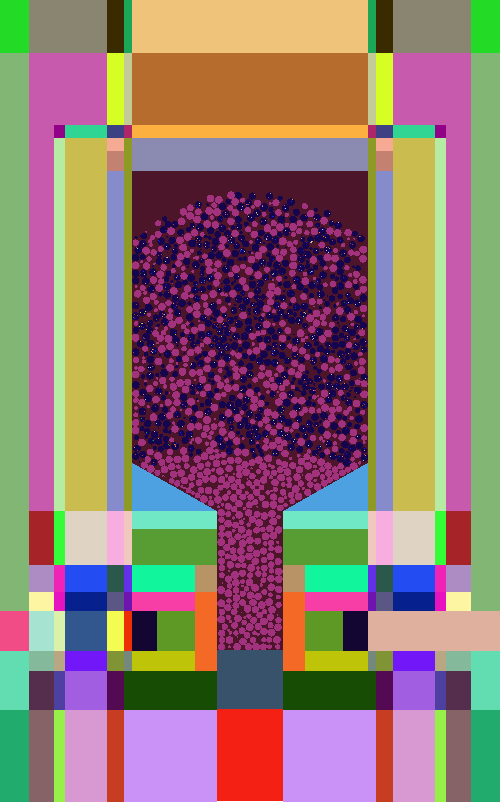

convert: /bin/../lib/././libuuid.so.1: no version information available (required by /lib/x86_64-linux-gnu/libSM.so.6)


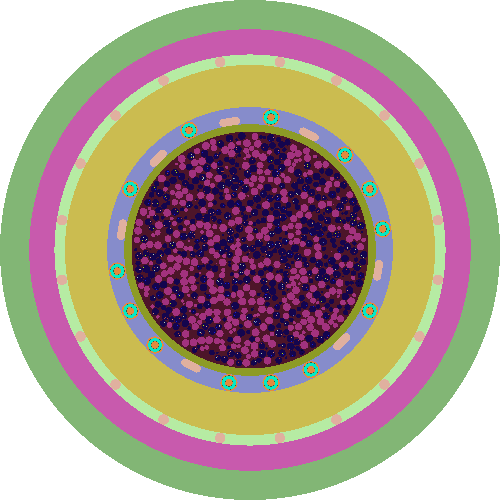

In [13]:
print('========Print to PPM plots========')
res=500

plot1 = openmc.Plot(plot_id=1)
plot1.filename = 'materials-xz-0'
plot1.basis='xz'
plot1.origin = [0, 0, 46.818]
plot1.width = [380, 610]
plot1.pixels = [res, int(610*res/380)]
plot1.color_by = 'material'

plot2 = openmc.Plot(plot_id=2)
plot2.filename = 'materials-xy-0'
plot2.basis='xy'
plot2.origin = [0, 0, (352.818-(171.2+(394.2-171.2)*0.45))]
plot2.width = [380, 380]
plot2.pixels = [res, res]
plot2.color_by = 'material'

plots = openmc.Plots([plot1,plot2])
plots.export_to_xml()

openmc.plot_inline(plot1)
openmc.plot_inline(plot2)
os.chdir('../')

The Fisile object can also read the existing depletion_result and store it as new matlist variable. This can be used to continue to next DEM step without loosing the ties between material depletion and pebble position.

In [14]:
Fisile.read('depletion_results.h5')
pd.DataFrame.from_dict({k: Fisile.matlist[0][k] for k in Fisile.matlist[0].keys()& {'atom den','atom fr','mass fr','isotope'}})

,atom fr,isotope,mass fr,atom den
0,2.663951e-15,Ag107,3.176168e-15,1.858282e-16
1,2.670922e-07,Ag109,3.244003e-07,1.863145e-08
2,1.403011e-11,Ag109_m1,1.704045e-11,9.786929e-13
3,4.998643e-14,Ag110,6.126866e-14,3.486884e-15
4,3.744332e-11,Ag110_m1,4.589449e-11,2.611919e-12
...,...,...,...,...
218,4.670645e-05,Y91,4.736002e-05,3.258084e-06
219,3.994829e-06,Zr91,4.050729e-06,2.786657e-07
220,5.522448e-05,Zr93,5.722795e-05,3.852273e-06
221,5.250151e-05,Zr95,5.557622e-05,3.662328e-06


Here we plot the pebble object as .vtu data.

In [15]:
PU.vtk_PolyDataFile(Pebble.Pebbledf.copy(),'./0/Data_0')

For next DEM step, we need to change **step** variable with +=1. Then, the rest will be the same as before. The **label** method will not delete the previous ties between Pebble ID and label, even though it used different DEM dump. This was done to keep track the Pebble material depletion. Instead, **label** will add label to unlabelled pebble. In this case, it is segmented by 1 segment in axial direction, 3 radial segment and 1 angular segment. Since the unlabelled pebble is the fresh fuel, it will have same properties as **initial_condition**.

In [16]:
Pebble.step+=1

filepath = int(initial+(deltas*timeline[1])+1*100000)
Pebble.read('./DEM_post/pebble_'+str(filepath)+'.vtk')
Pebble.label(PU.radial_axial,axial_segment=1,radial_segment=3,angle_segment=1)

for j in range(max(Pebble.Pebbledf['label'])-3,max(Pebble.Pebbledf['label'])):
    Fisile.add(Initial_condition[0],Initial_condition[1],
               10.4,8335*(4/3)*math.pi*(0.025**3),j+1,
               Pebble.Pebbledf,fraction_type='atom fr')
Fisile.write_material()

pd.DataFrame({k: Pebble.Pebbledf[k] for k in Pebble.Pebbledf.keys()& {'id','x','y','z','rho','theta','type','label'}})

,theta,y,z,rho,label,id,type,x
0,3.765045,-12.62440,-343.883,0.216230,0,1,2,-17.555000
1,4.859636,-21.64510,-341.452,0.218819,0,2,2,3.210410
2,4.539106,-20.72290,-345.274,0.210380,0,3,2,-3.627300
3,2.157357,18.20940,-345.959,0.218640,0,4,2,-12.101700
4,2.652850,10.25770,-349.888,0.218474,0,5,2,-19.289600
...,...,...,...,...,...,...,...,...
29485,1.375626,84.86870,180.781,0.865111,0,29486,1,16.777400
29486,4.942923,-20.02860,207.584,0.205729,0,29487,2,4.700840
29487,4.658975,-6.68144,207.682,0.066910,0,29488,2,-0.357225
29488,5.644248,-51.79100,179.920,0.868477,0,29489,1,69.715300


Here is the implementation to the Pebble core universe and plot of it.

/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Plot instance already exists with id=1.
  warn(msg, IDWarning)
/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Plot instance already exists with id=2.
  warn(msg, IDWarning)
convert: /bin/../lib/././libuuid.so.1: no version information available (required by /lib/x86_64-linux-gnu/libSM.so.6)


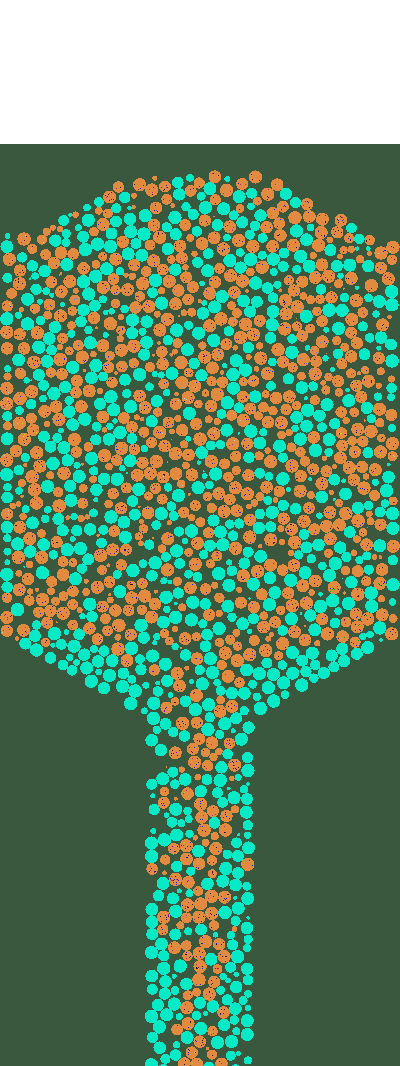

convert: /bin/../lib/././libuuid.so.1: no version information available (required by /lib/x86_64-linux-gnu/libSM.so.6)


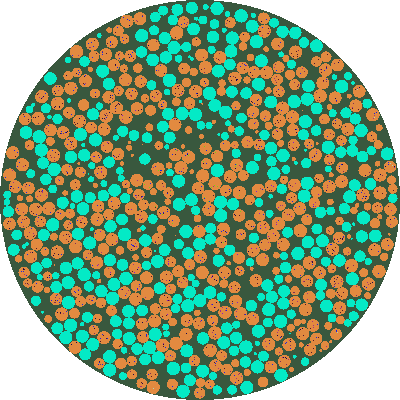

convert: /bin/../lib/././libuuid.so.1: no version information available (required by /lib/x86_64-linux-gnu/libSM.so.6)


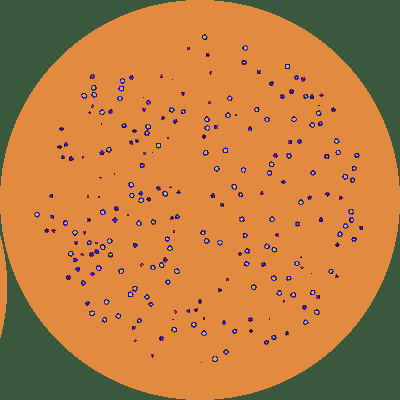

convert: /bin/../lib/././libuuid.so.1: no version information available (required by /lib/x86_64-linux-gnu/libSM.so.6)


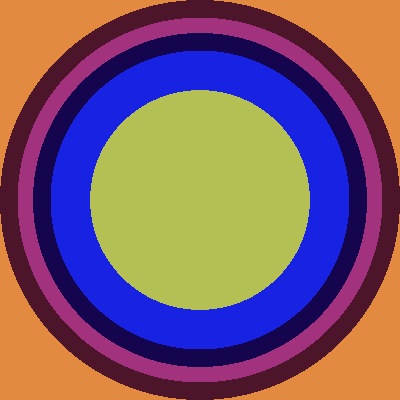

In [17]:
Core = HTR10.HTR10_Core_Universe(Pebble.Pebbledf,Fisile.kernel_material)
Core.create_TRISO()
Core.create_Pebble(TRIpos)
Core.create_Core()
Core.visualize(res=400,dirs='visualize/')